## Required imports and config

In [1]:
import math
import pandas as pd
import numpy as np
import json
import io
import boto3

from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
ENDPOINT_COS_KERAS = 'VR-keras-cos-endpoint-2020-10-15-15-27'
ENDPOINT_SIN_KERAS = 'VR-keras-sin-endpoint-2020-10-16-07-41'
ENDPOINT_COS_LINEAR ='VR-cos-regression-endpoint-202009251406'
ENDPOINT_SIN_LINEAR  = 'VR-sin-regression-endpoint-202009251406'

## Load data and sample a few random values for testing

In [3]:
data = pd.read_csv('../all-in-one.csv')

data['cos_attack_angle'] = data['angle_of_attack'].apply(lambda x: np.cos(np.deg2rad(x)))
data['sin_attack_angle'] = data['angle_of_attack'].apply(lambda x: np.sin(np.deg2rad(x)))
data.drop(columns=['angle_of_attack'], inplace=True)
data = data[['boat_speed','cos_attack_angle', 'sin_attack_angle', 'wind_speed','cos_target_angle', 'sin_target_angle', 'sin_boat_angle', 'cos_boat_angle']]

In [4]:
data_cos = data.drop(columns=['sin_boat_angle'])
data_sin = data.drop(columns=['cos_boat_angle'])

print(len(data_cos))

3690


In [5]:
# modify the next two lines in order to sample fewer rows
sample_size = len(data_cos)
data_test_cos = data_cos.sample(sample_size)
data_test_sin = data_sin.sample(sample_size)


test_cos_X = data_test_cos.drop(columns=['cos_boat_angle']).to_numpy()
test_cos_y = data_test_cos['cos_boat_angle'].to_numpy()

test_sin_X = data_test_sin.drop(columns=['sin_boat_angle']).to_numpy()
test_sin_y = data_test_sin['sin_boat_angle'].to_numpy()

print(test_cos_X.shape)

(3690, 6)


## Retrieve predictions from nonlinear keras endpoints

In [6]:
import json

runtime = boto3.client('runtime.sagemaker')

payload_cos = json.dumps(test_cos_X.tolist())
response_cos = runtime.invoke_endpoint(EndpointName=ENDPOINT_COS_KERAS,
                                   Body=payload_cos)
result_cos = json.loads(response_cos['Body'].read().decode())
test_pred_cos = np.array([r for r in result_cos['outputs']['score']['floatVal']])


payload_sin = json.dumps(test_sin_X.tolist())
response_sin = runtime.invoke_endpoint(EndpointName=ENDPOINT_SIN_KERAS,
                                   Body=payload_sin)
result_sin = json.loads(response_sin['Body'].read().decode())
test_pred_sin = np.array([r for r in result_sin['outputs']['score']['floatVal']])

In [7]:
print(test_pred_cos[:4])
print(test_pred_sin[:4])

[-0.36063331  0.14050257 -0.90403181 -0.95693284]
[-0.92012382  0.90870035  0.90861404  0.90855014]


## Retrieve predictions from linear regression endpoints

In [8]:
data = pd.read_csv('../all-in-one.csv')

# The column to predict has to be in last position
data_linear = data[['boat_speed','angle_of_attack','wind_speed','cos_target_angle', 'sin_target_angle', 'cos_boat_angle', 'sin_boat_angle']]
test_linear_cos_X = data_linear.iloc[:,:-2].to_numpy()
test_linear_sin_X = data_linear.iloc[:,:-2].to_numpy()

test_linear_cos_y = data_linear.iloc[:,-2].to_numpy()
test_linear_sin_y = data_linear.iloc[:,-1].to_numpy()

In [9]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

In [10]:
payload_cos_linear = np2csv(test_linear_cos_X)
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_COS_LINEAR,
                                   ContentType='text/csv',
                                   Body=payload_cos_linear)
result = json.loads(response['Body'].read().decode())
test_pred_cos_linear = np.array([r['score'] for r in result['predictions']])

In [11]:
payload_sin_linear = np2csv(test_linear_sin_X)
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_COS_LINEAR,
                                   ContentType='text/csv',
                                   Body=payload_sin_linear)
result = json.loads(response['Body'].read().decode())
test_pred_sin_linear = np.array([r['score'] for r in result['predictions']])

## Cap all predictions to be between -1 and 1

In [12]:
test_pred_cos = [cos_val if -1 <= cos_val <= 1 else 2 * int( cos_val > 1) - 1 for cos_val in test_pred_cos]
test_pred_sin = [sin_val if -1 <= sin_val <= 1 else 2 * int( sin_val > 1) - 1 for sin_val in test_pred_sin]

test_pred_cos_linear = [cos_val if -1 <= cos_val <= 1 else 2 * int( cos_val > 1) - 1 for cos_val in test_pred_cos_linear]
test_pred_sin_linear = [cos_val if -1 <= cos_val <= 1 else 2 * int( cos_val > 1) - 1 for cos_val in test_pred_sin_linear]

In [13]:
from sklearn.metrics import mean_squared_error

mse_cos = mean_squared_error(test_cos_y, test_pred_cos)
print(f"Cosine test MSE: {round(mse_cos,4)}, \n")

mse_sin = mean_squared_error(test_sin_y, test_pred_sin)
print(f"Sine test MSE: {round(mse_sin,4)}, \n")


Cosine test MSE: 0.0102, 

Sine test MSE: 0.0044, 



## Measure the accuracy on the actual angle values

In [14]:
pred_angles_keras = np.array([
    round(math.degrees(math.acos(cos_val)),2)
    if sin_val > 0 else round(360 - math.degrees(math.acos(cos_val)),2)
    for sin_val, cos_val in zip(test_pred_sin, test_pred_cos)])
actual_angles_keras = np.array([
    round(math.degrees(math.acos(cos_val)),2)
    if sin_val > 0 else round(360 - math.degrees(math.acos(cos_val)),2)
    for sin_val, cos_val in zip(test_sin_y, test_cos_y)])

pred_angles_linear = np.array([
    round(math.degrees(math.acos(cos_val)),2)
    if sin_val > 0 else round(360 - math.degrees(math.acos(cos_val)),2)
    for sin_val, cos_val in zip(test_pred_sin_linear, test_pred_cos_linear)])
actual_angles_linear = np.array([
    round(math.degrees(math.acos(cos_val)),2)
    if sin_val > 0 else round(360 - math.degrees(math.acos(cos_val)),2)
    for sin_val, cos_val in zip(test_linear_sin_y, test_linear_cos_y)])

In [15]:
deg_error_threshold = 15
absolute_error_keras = np.absolute(pred_angles_keras - actual_angles_keras)

abs_error_keras = [(e, i) for i, e in enumerate(absolute_error_keras)]
abs_error_keras.sort()

num_above_threshold = sum(1 for e, i in abs_error_keras if e > deg_error_threshold)
num_below_threshold = sample_size - num_above_threshold


## Results for Keras models

In [16]:
print(f'Total data points tested: {len(absolute_error_keras)}')
print(f'Number of data points with angle error more than {deg_error_threshold} degrees: {num_above_threshold}')
print(f'Number of data points with angle error less than {deg_error_threshold} degrees: {num_below_threshold}')

Total data points tested: 3690
Number of data points with angle error more than 15 degrees: 226
Number of data points with angle error less than 15 degrees: 3464


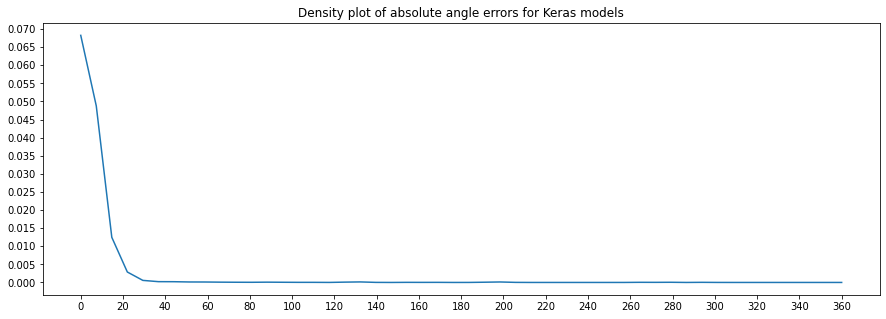

In [17]:
density = gaussian_kde(absolute_error_keras)
xs = np.linspace(0,360,50)
plt.figure(figsize=(15,5))
plt.plot(xs,density(xs))
plt.locator_params(axis='y', nbins=20)
plt.locator_params(axis='x', nbins=30)
plt.title('Density plot of absolute angle errors for Keras models')
plt.show()

## Results for linear models

In [18]:
absolute_error_linear = np.absolute(pred_angles_linear - actual_angles_linear)
abs_error_linear = [(e, i) for i, e in enumerate(absolute_error_linear)]
abs_error_linear.sort()

num_above_threshold = sum(1 for e, i in abs_error_linear if e > deg_error_threshold)
num_below_threshold = sample_size - num_above_threshold

print(f'Total data points tested: {len(absolute_error_linear)}')
print(f'Number of data points with angle error more than {deg_error_threshold} degrees: {num_above_threshold}')
print(f'Number of data points with angle error less than {deg_error_threshold} degrees: {num_below_threshold}')

Total data points tested: 3690
Number of data points with angle error more than 15 degrees: 2268
Number of data points with angle error less than 15 degrees: 1422


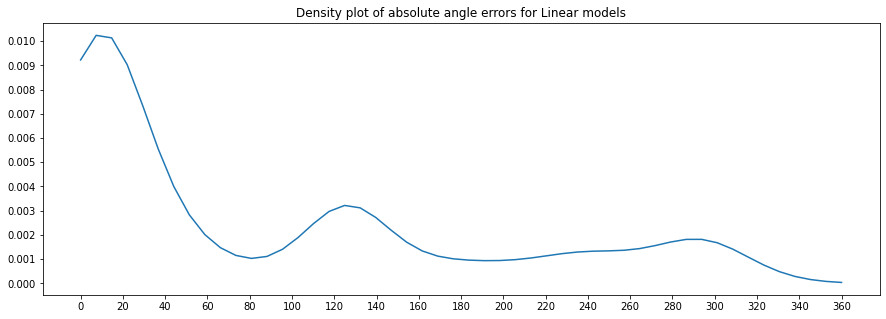

In [19]:
density = gaussian_kde(absolute_error_linear)
xs = np.linspace(0,360,50)
plt.figure(figsize=(15,5))
plt.plot(xs,density(xs))
plt.locator_params(axis='y', nbins=20)
plt.locator_params(axis='x', nbins=30)
plt.title('Density plot of absolute angle errors for Linear models')
plt.show()